In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset



tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("data/train.csv", sep=",")

# california_housing_dataframe = california_housing_dataframe.dropna()
# print(california_housing_dataframe)

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["TotRmsAbvGrd"] <= 13]
california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["OverallQual"] <= 9.5]
california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["GrLivArea"] <= 3500]

# housing_dataframe.reset_index(drop=True)
# housing_dataframe = housing_dataframe.reindex(
#     np.random.permutation(housing_dataframe.index))

# clipped_feature = california_housing_dataframe["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
# california_housing_dataframe["TotRmsAbvGrd"] = clipped_feature

# clipped_feature = california_housing_dataframe["OverallQual"].apply(lambda x: min(x, 9.5))
# california_housing_dataframe["OverallQual"] = clipped_feature

# clipped_feature = california_housing_dataframe["GrLivArea"].apply(lambda x: max(x, 3500))
# california_housing_dataframe["GrLivArea"] = clipped_feature

In [2]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["OverallQual",
     "TotalBsmtSF",
     "1stFlrSF",
     "GrLivArea",
     "FullBath",
     "TotRmsAbvGrd",
     "Fireplaces",
     "GarageYrBlt",
     "GarageCars",
     "GarageArea"]]
  processed_features = selected_features.copy()


#   # ####################################################################################clipping_features
#   clipped_feature = processed_features["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
#   processed_features["TotRmsAbvGrd"] = clipped_feature

#   clipped_feature = processed_features["OverallQual"].apply(lambda x: min(x, 9))
#   processed_features["OverallQual"] = clipped_feature

#   clipped_feature = processed_features["GrLivArea"].apply(lambda x: min(x, 3500))
#   processed_features["GrLivArea"] = clipped_feature


  # Create a synthetic feature.
#   processed_features["rooms_per_person"] = (
#     california_housing_dataframe["total_rooms"] /
#     california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["SalePrice"] = california_housing_dataframe["SalePrice"] / 1000.0
  return output_targets
california_housing_dataframe

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
938,939,60,RL,73.0,8760,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2006,New,Partial,239799
29,30,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,68500
637,638,190,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,93000
1129,1130,90,RM,60.0,7200,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,140000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,159,60,FV,100.0,12552,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2010,WD,Normal,254900
982,983,20,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,159895
1326,1327,30,RH,70.0,4270,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,79000
1294,1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,115000


In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(1000))
training_targets = preprocess_targets(california_housing_dataframe.head(1000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(460))
validation_targets = preprocess_targets(california_housing_dataframe.tail(460))

# display.display(california_housing_dataframe.describe())

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())


Training examples summary:


,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,942.0,1000.0,1000.0
mean,6.0,1039.6,1141.8,1492.0,1.5,6.5,0.6,1977.6,1.8,465.2
std,1.3,400.3,360.4,486.3,0.5,1.6,0.6,25.1,0.8,212.2
min,1.0,0.0,334.0,334.0,0.0,2.0,0.0,1900.0,0.0,0.0
25%,5.0,787.0,874.0,1121.8,1.0,5.0,0.0,1961.0,1.0,308.0
50%,6.0,990.0,1072.0,1440.0,2.0,6.0,1.0,1978.0,2.0,475.0
75%,7.0,1271.2,1363.0,1744.5,2.0,7.0,1.0,2001.0,2.0,576.0
max,9.0,3206.0,3228.0,3493.0,3.0,12.0,3.0,2010.0,4.0,1390.0


Validation examples summary:


,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
count,460.0,460.0,460.0,460.0,460.0,460.0,460.0,438.0,460.0,460.0
mean,6.1,1048.5,1165.8,1498.4,1.6,6.5,0.6,1979.0,1.8,475.5
std,1.3,405.9,366.1,474.1,0.5,1.5,0.6,24.1,0.7,202.0
min,3.0,0.0,483.0,605.0,0.0,3.0,0.0,1908.0,0.0,0.0
25%,5.0,804.0,886.8,1130.8,1.0,5.0,0.0,1961.0,1.0,352.0
50%,6.0,979.0,1098.0,1473.5,2.0,6.0,1.0,1979.5,2.0,479.0
75%,7.0,1287.5,1414.0,1774.0,2.0,7.0,1.0,2002.0,2.0,576.0
max,9.0,2524.0,2898.0,3447.0,3.0,12.0,2.0,2009.0,4.0,1166.0


Training targets summary:


,SalePrice
count,1000.0
mean,176.1
std,70.8
min,34.9
25%,130.0
50%,160.0
75%,208.6
max,556.6


Validation targets summary:


,SalePrice
count,460.0
mean,180.7
std,75.5
min,40.0
25%,129.4
50%,165.5
75%,214.0
max,611.7


In [4]:
# #find good feratures based on sale price
# correlation_dataframe = california_housing_dataframe.copy()
# correlation_dataframe["target"] = california_housing_dataframe["SalePrice"]

# # display.display(training_targets.describe())

# correlation_dataframe.corr()
# new = pd.DataFrame()
# new['target'] = correlation_dataframe.corr()['target']
# new.to_csv('corr.csv')
# # correlation_dataframe["OpenPorchSF"].corr()

In [5]:
correlation_dataframe = california_housing_dataframe.copy()
correlation_dataframe["target"] = training_targets["SalePrice"]

# display.display(training_targets.describe())
# pd.options.display.max_rows = 20

new = correlation_dataframe.corr()
new['target'].sort_values(ascending=False).head(10)


target         1.0
SalePrice      1.0
OverallQual    0.8
GrLivArea      0.7
GarageCars     0.7
TotalBsmtSF    0.6
1stFlrSF       0.6
GarageArea     0.6
FullBath       0.6
YearRemodAdd   0.5
Name: target, dtype: float64

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


In [7]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [8]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

In [9]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [10]:
# minimal_features = [
#      "OverallQual",
#      "GrLivArea",
# #      "TotRmsAbvGrd",
#      "TotalBsmtSF",
# #      "1stFlrSF",
# #      "FullBath",
#      "Fireplaces",
#      "GarageYrBlt",#nan
# #      "GarageCars",
#      "GarageArea"
# ]


###########################
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #

#   clipped_feature = examples_dataframe["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
#   examples_dataframe["TotRmsAbvGrd"] = clipped_feature
#   # california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["TotRmsAbvGrd"] <= 13]

#   clipped_feature = examples_dataframe["OverallQual"].apply(lambda x: min(x, 9.5))
#   examples_dataframe["OverallQual"] = clipped_feature
#   # california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["OverallQual"] <= 9.5]

#   clipped_feature = examples_dataframe["GrLivArea"].apply(lambda x: min(x, 3500)) #was max
#   examples_dataframe["GrLivArea"] = clipped_feature    
    
#   examples_dataframe = examples_dataframe[examples_dataframe["TotRmsAbvGrd"] <= 13]
#   examples_dataframe = examples_dataframe[examples_dataframe["OverallQual"] <= 9.5]
#   examples_dataframe = examples_dataframe[examples_dataframe["GrLivArea"] <= 3500]
    
  new = pd.DataFrame()
  new["OverallQual"] = linear_scale(examples_dataframe["OverallQual"])
  new["GrLivArea"] = linear_scale(examples_dataframe["GrLivArea"])
#   new["TotRmsAbvGrd"] = linear_scale(examples_dataframe["TotRmsAbvGrd"])
  new["TotalBsmtSF"] = linear_scale(examples_dataframe["TotalBsmtSF"])
#   new["1stFlrSF"] = linear_scale(examples_dataframe["1stFlrSF"])
#   new["FullBath"] = linear_scale(examples_dataframe["FullBath"])
  new["Fireplaces"] = linear_scale(examples_dataframe["Fireplaces"])
#   new["GarageYrBlt"] = linear_scale(examples_dataframe["GarageYrBlt"])
#   new["GarageCars"] = linear_scale(examples_dataframe["GarageCars"])
  new["GarageArea"] = linear_scale(examples_dataframe["GarageArea"])
#   new["SalePrice"] = examples_dataframe["SalePrice"]
  
  return new

##############
# clipped_feature = california_housing_dataframe["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
# california_housing_dataframe["TotRmsAbvGrd"] = clipped_feature
# # california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["TotRmsAbvGrd"] <= 13]

# clipped_feature = california_housing_dataframe["OverallQual"].apply(lambda x: min(x, 9.5))
# california_housing_dataframe["OverallQual"] = clipped_feature
# # california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["OverallQual"] <= 9.5]

# clipped_feature = california_housing_dataframe["GrLivArea"].apply(lambda x: min(x, 3500)) #was max
# california_housing_dataframe["GrLivArea"] = clipped_feature
# california_housing_dataframe = california_housing_dataframe[california_housing_dataframe["GrLivArea"] <= 3500]
###########

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
# normalized_dataframe.dropna()
# print(normalized_dataframe.isnull().sum())
normalized_training_examples = normalized_dataframe.head(1000)
normalized_validation_examples = normalized_dataframe.tail(460)


################################


# # clipped_feature = california_housing_dataframe["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
# # california_housing_dataframe["TotRmsAbvGrd"] = clipped_feature

# # clipped_feature = california_housing_dataframe["OverallQual"].apply(lambda x: min(x, 9.5))
# # california_housing_dataframe["OverallQual"] = clipped_feature

# # clipped_feature = california_housing_dataframe["GrLivArea"].apply(lambda x: max(x, 3500))
# # california_housing_dataframe["GrLivArea"] = clipped_feature

# minimal_training_examples = training_examples[minimal_features]
# # clipped_feature = minimal_training_examples["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
# # minimal_training_examples["TotRmsAbvGrd"] = clipped_feature

# clipped_feature = training_examples["OverallQual"].apply(lambda x: min(x, 9.5))
# training_examples["OverallQual"] = clipped_feature

# clipped_feature = training_examples["GarageArea"].apply(lambda x: min(x, 1000))
# training_examples["GarageArea"] = clipped_feature

# # clipped_feature = minimal_training_examples["GrLivArea"].apply(lambda x: max(x, 3500))
# # minimal_training_examples["GrLivArea"] = clipped_feature


# minimal_validation_examples = validation_examples[minimal_features]



Training model...
RMSE (on training data):
  period 00 : 28.69
  period 01 : 28.08
  period 02 : 28.02
  period 03 : 27.97
  period 04 : 27.94
  period 05 : 27.87
  period 06 : 27.55
  period 07 : 27.56
  period 08 : 27.44
  period 09 : 27.27
Model training finished.
Final RMSE (on training data):   27.27
Final RMSE (on validation data): 30.35


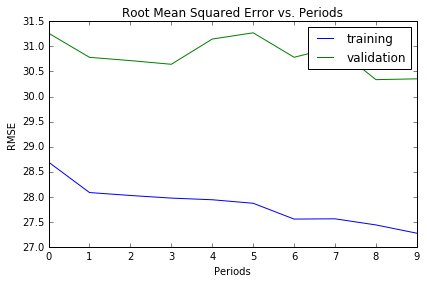

In [11]:
# nn_regressor = train_nn_regression_model(
#     my_optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
#     steps=2000,
#     batch_size=40,
#     hidden_units=[10, 4],
#     training_examples=minimal_training_examples,#normalized_training_examples,#minimal_training_examples,
#     training_targets=training_targets,
#     validation_examples=minimal_validation_examples,#normalized_validation_examples,#
#     validation_targets=validation_targets
# )

# With normalized values it is under 33, but is overfitting
dnn_regressor, rsm, validation = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
    steps=5000,
    batch_size=100,
    hidden_units=[10, 7],
    training_examples=normalized_training_examples,#minimal_training_examples,#minimal_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,#minimal_validation_examples,
    validation_targets=validation_targets#validation_targets
)

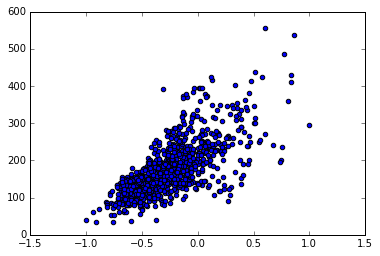

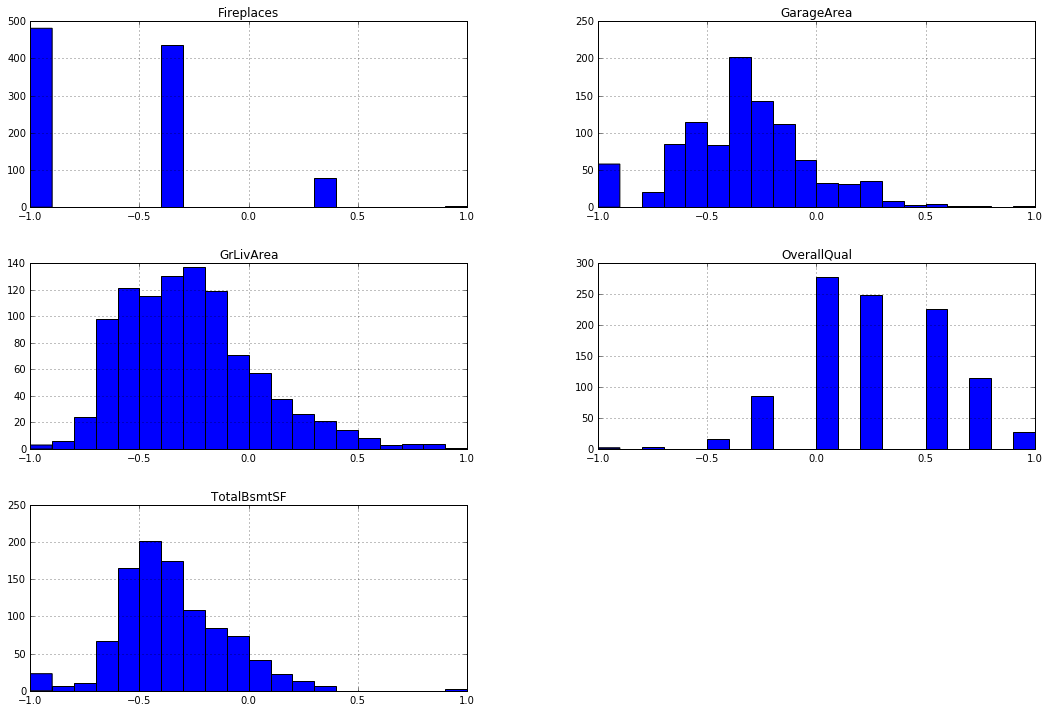

In [12]:
# plt.scatter(training_examples["OverallQual"], training_targets["SalePrice"])
# plt.scatter(normalized_training_examples["OverallQual"], training_targets["SalePrice"])
plt.scatter(normalized_training_examples["GrLivArea"], training_targets["SalePrice"])
# plt.scatter(training_examples["TotalBsmtSF"], training_targets["SalePrice"])
# plt.scatter(normalized_training_examples["GarageArea"], training_targets["SalePrice"])
# plt.scatter(training_examples["GarageYrBlt"], training_targets["SalePrice"])
# training_examples["OverallQual"].hist()
# training_examples["GrLivArea"].hist()
# training_examples["TotalBsmtSF"].hist()
# training_examples["GarageArea"].hist()
# training_examples["GarageYrBlt"]#.hist()

_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [36]:
california_housing_test_data = pd.read_csv("data/test.csv", sep=",")
california_housing_saleprice_data = pd.read_csv("data/sample_submission.csv", sep=",")

# inds = pd.isnull(california_housing_test_data).any().notnull()#.nonzero()[0]
# inds = np.where(california_housing_test_data.notnull())

# print(california_housing_test_data.notnull().sum())
# print(inds)
# california_housing_saleprice_data = california_housing_saleprice_data.iloc[california_housing_test_data.isnull().index()]
# california_housing_test_data = california_housing_test_data.dropna()#iloc[inds[0]]

# normalize_linear_scale(preprocess_features(california_housing_dataframe))

print(california_housing_test_data)#.index.values
# california_housing_saleprice_data = california_housing_saleprice_data.iloc[inds[0]]
# for i in california_housing_test_data:
    
    
# print(california_housing_test_data.isnull().sum())

# california_housing_test_data = california_housing_test_data[california_housing_test_data["TotRmsAbvGrd"] <= 13]
# california_housing_test_data = california_housing_test_data[california_housing_test_data["OverallQual"] <= 9.5]
# california_housing_test_data = california_housing_test_data[california_housing_test_data["GrLivArea"] <= 3500]

new_examples = normalize_linear_scale(preprocess_features(california_housing_test_data))#.dropna()
new_targets = preprocess_targets(california_housing_saleprice_data)#.dropna())
# new_examples.fillna()
# print("YESSSSSSSS",new_examples.isnull().sum())
# # ### Double-check
# print("New examples summary:")
# display.display(new_examples.describe())
# print("New Targets summary:")
display.display(new_targets.describe())

# new_examples.drop(new_examples.index[[2577-1461,2121-1461]], inplace=True)
# new_targets.drop(new_targets.index[[2577-1461,2121-1461]], inplace=True)


# # new_examples.isnull().sum()
print(new_examples)
# # # new1.sort_values(ascending=True)

# new_examples.fillna(new_examples.mean())

predict_new_input_fn = lambda: my_input_fn(new_examples, new_targets["SalePrice"], num_epochs=1, shuffle=False)

new_predictions = dnn_regressor.predict(input_fn=predict_new_input_fn)
new_predictions = np.array([item['predictions'][0] for item in new_predictions])


#Obtain mean of columns as you need, nanmean is just convenient.
col_mean = np.nanmean(new_predictions, axis=0)
print("avg",col_mean)


#Find indicies that you need to replace
inds = np.where(np.isnan(new_predictions))
print(inds)

#Place column means in the indices. Align the arrays using take
new_predictions[inds] = [col_mean,col_mean]#np.take(col_mean, inds[1])
print("YES")
print(new_predictions)


# new_preditions=new_predictions[0:2577-1461] = 100

# new_predictions.fillna(new_predictions.mean())

# new_predictions = new_predictions[0:2121-1462]
# new_targets = new_targets[0:2121-1462]# = 100
# # new = pd.DataFrame()
# # new['SalePrice'] = 0
new = pd.DataFrame(new_predictions, columns=["SalePrice"])#[1], index=new_predictions[0])
print(new)
# new.index += 1461
new.index.name = 'Id'
new_targets.index.name = 'Id'
new.rename({0:"SalePrice"})#, axis='columns')#[0].rename = 'SalePrice'
# new["SalePrice"] *= 1000
new.to_csv('predictions1.csv')
# # print(new.isnull().sum())




new_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(new, new_targets))

print("Final RMSE (on test data): %0.2f" % new_root_mean_squared_error)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities      ...       ScreenPor

,SalePrice
count,1459.0
mean,179.2
std,16.5
min,135.8
25%,168.7
50%,179.2
75%,186.8
max,281.6


      OverallQual  GrLivArea  TotalBsmtSF  Fireplaces  GarageArea
0            -0.1       -0.8         -0.7        -1.0        -0.0
1             0.1       -0.6         -0.5        -1.0        -0.6
2            -0.1       -0.5         -0.6        -0.5        -0.4
3             0.1       -0.5         -0.6        -0.5        -0.4
4             0.6       -0.6         -0.5        -1.0        -0.3
...           ...        ...          ...         ...         ...
1454         -0.3       -0.7         -0.8        -1.0        -1.0
1455         -0.3       -0.7         -0.8        -1.0        -0.6
1456         -0.1       -0.7         -0.5        -0.5        -0.2
1457         -0.1       -0.8         -0.6        -1.0        -1.0
1458          0.3       -0.3         -0.6        -0.5        -0.1

[1459 rows x 5 columns]
avg 133.78777
(array([ 660, 1116]),)
YES
[108.90507  122.02025  120.947876 ... 121.332535  87.754654 165.99982 ]
      SalePrice
0         108.9
1         122.0
2         120.9
3     

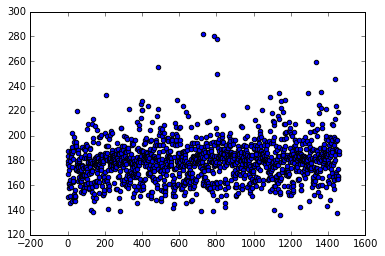

In [33]:
# print(new_targets)
# print(new)
plt.scatter(new_targets.index, new_targets["SalePrice"])

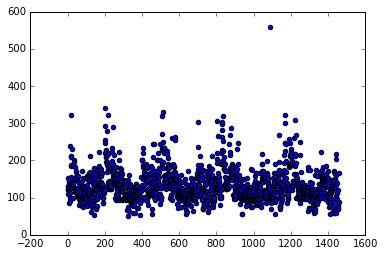

In [34]:
plt.scatter(new.index, new["SalePrice"])

In [14]:
# # california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]

# calibration_data = train_model(
#     learning_rate=.5,
#     steps=500,
#     batch_size=5,
#     input_feature="OverallQual"
# )

In [15]:
# def train_model(learning_rate, steps, batch_size, input_feature):
#   """Trains a linear regression model.
  
#   Args:
#     learning_rate: A `float`, the learning rate.
#     steps: A non-zero `int`, the total number of training steps. A training step
#       consists of a forward and backward pass using a single batch.
#     batch_size: A non-zero `int`, the batch size.
#     input_feature: A `string` specifying a column from `california_housing_dataframe`
#       to use as input feature.
      
#   Returns:
#     A Pandas `DataFrame` containing targets and the corresponding predictions done
#     after training the model.
#   """
  
#   periods = 10
#   steps_per_period = steps // periods

#   my_feature = input_feature
#   my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
#   my_label = "SalePrice"
#   targets = california_housing_dataframe[my_label].astype('float32')

#   # Create input functions.
#   training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
#   predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
#   # Create feature columns.
#   feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
#   # Create a linear regressor object.
#   my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#   my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
#   linear_regressor = tf.estimator.LinearRegressor(
#       feature_columns=feature_columns,
#       optimizer=my_optimizer
#   )

#   # Set up to plot the state of our model's line each period.
#   plt.figure(figsize=(15, 6))
#   plt.subplot(1, 2, 1)
#   plt.title("Learned Line by Period")
#   plt.ylabel(my_label)
#   plt.xlabel(my_feature)
#   sample = california_housing_dataframe.sample(n=300)
#   plt.scatter(sample[my_feature], sample[my_label])
#   colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

#   # Train the model, but do so inside a loop so that we can periodically assess
#   # loss metrics.
#   print("Training model...")
#   print("RMSE (on training data):")
#   root_mean_squared_errors = []
#   for period in range (0, periods):
#     # Train the model, starting from the prior state.
#     linear_regressor.train(
#         input_fn=training_input_fn,
#         steps=steps_per_period,
#     )
#     # Take a break and compute predictions.
#     predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
#     predictions = np.array([item['predictions'][0] for item in predictions])
    
#     # Compute loss.
#     root_mean_squared_error = math.sqrt(
#       metrics.mean_squared_error(predictions, targets))
#     # Occasionally print the current loss.
#     print("  period %02d : %0.2f" % (period, root_mean_squared_error))
#     # Add the loss metrics from this period to our list.
#     root_mean_squared_errors.append(root_mean_squared_error)
#     # Finally, track the weights and biases over time.
#     # Apply some math to ensure that the data and line are plotted neatly.
#     y_extents = np.array([0, sample[my_label].max()])
    
#     weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
#     bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
#     x_extents = (y_extents - bias) // weight
#     x_extents = np.maximum(np.minimum(x_extents,
#                                       sample[my_feature].max()),
#                            sample[my_feature].min())
#     y_extents = weight * x_extents + bias
#     plt.plot(x_extents, y_extents, color=colors[period]) 
#   print("Model training finished.")

#   # Output a graph of loss metrics over periods.
#   plt.subplot(1, 2, 2)
#   plt.ylabel('RMSE')
#   plt.xlabel('Periods')
#   plt.title("Root Mean Squared Error vs. Periods")
#   plt.tight_layout()
#   plt.plot(root_mean_squared_errors)

#   # Create a table with calibration data.
#   calibration_data = pd.DataFrame()
#   calibration_data["predictions"] = pd.Series(predictions)
#   calibration_data["targets"] = pd.Series(targets)
#   display.display(calibration_data.describe())

#   print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
#   return calibration_data